# Followup on Duffing Oscillator

Our approach to modeling the Duffing Oscillator is very much like a typical computational physics project.  We used a robust package, `DifferentialEquations.jl`, then made a number of functions and objects which interfaced with it to answer the questions we had.  Probably 90% of computational physics uses this paradigm.

We are now going to do a bit more analysis of the Duffing Oscillator, with the aim of understanding some of the interesting physics that we observed.

## Lyupanov Exponents

One thing we did not do in the lab is actually calculate the Lyupanov exponent.  Recall, the Lyupanov exponent quantifies how quickly two nearby trajectories diverge from one-another.

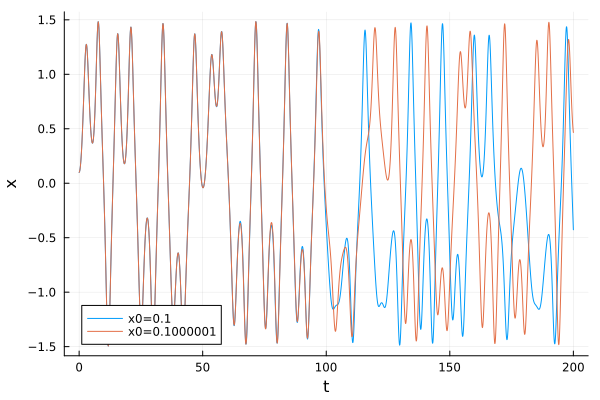

In [1]:
using DifferentialEquations,Plots

function duffing(initialxv,T,α,β,γ,F,ω)
    function dxvdt(xv,p,t)
        x,v = xv
        return[v,-2*γ*v-α*x-β*x^3+F*cos(ω*t)]
    end
    tspan=[0., T]
    prob=ODEProblem(dxvdt,initialxv,tspan)
    solve(prob)
end
duffing(initialxv,T;α,β,γ,F,ω)=duffing(initialxv,T,α,β,γ,F,ω)
duffing(;initialxv,T,α,β,γ,F,ω)=duffing(initialxv,T,α,β,γ,F,ω)

function plot_xt(trajectory,initialT,finalT,dT;opts...)
    xt=[(t,trajectory(t)[1]) for t in initialT:dT:finalT]
    plot(xt;opts...)
end

function plot_xt!(trajectory,initialT,finalT,dT;opts...)
    xt=[(t,trajectory(t)[1]) for t in initialT:dT:finalT]
    plot!(xt;opts...)
end

function plot_xv(trajectory,initialT,finalT,dT;opts...)
    xv=[(trajectory(t)[1],trajectory(t)[2]) for t in initialT:dT:finalT]
    plot(xv;opts...)
end

function plot_xv!(trajectory,initialT,finalT,dT;opts...)
    xv=[(trajectory(t)[1],trajectory(t)[2]) for t in initialT:dT:finalT]
    plot!(xv;opts...)
end

function scatter_xv(trajectory,initialT,finalT,dT;opts...)
    xv=[(trajectory(t)[1],trajectory(t)[2]) for t in initialT:dT:finalT]
    scatter(xv;opts...)
end

function scatter_xv!(trajectory,initialT,finalT,dT;opts...)
    xv=[(trajectory(t)[1],trajectory(t)[2]) for t in initialT:dT:finalT]
    scatter!(xv;opts...)
end

dparamsb=(α=-1,β=1,γ=0.1,F=0.35,ω=1)
traj1b=duffing([0.1,0],200;dparamsb...);
traj2b=duffing([0.1000001,0],200;dparamsb...);
plot_xt(traj1b,0,200,0.1;xlabel="t",ylabel="x",label="x0=0.1")
plot_xt!(traj2b,0,200,0.1;xlabel="t",ylabel="x",label="x0=0.1000001")

For those parameters the trajectories appeared to agree until roughly time t=100, and after that they are completely different.  

Lets plot the difference between the trajectories, on a log scale

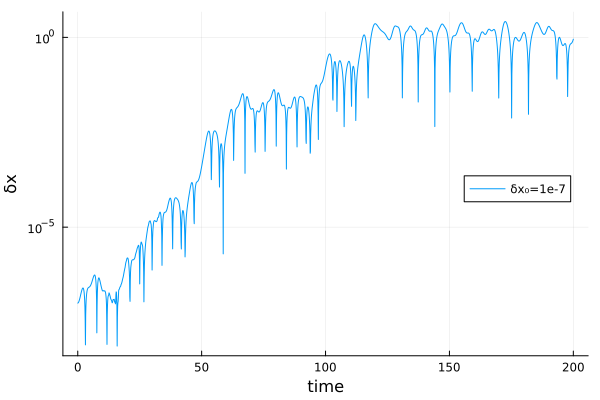

In [4]:
times=collect(0:0.1:200)
x1=[traj1b(t)[1] for t in times]
x2=[traj2b(t)[1] for t in times]
plot(times,abs.(x2-x1),yscale=:log10,
    xlabel="time",ylabel="δx",label="δx₀=1e-7",leg=:right)

It probably makes sense to only plot at times which are multiples of the drive period

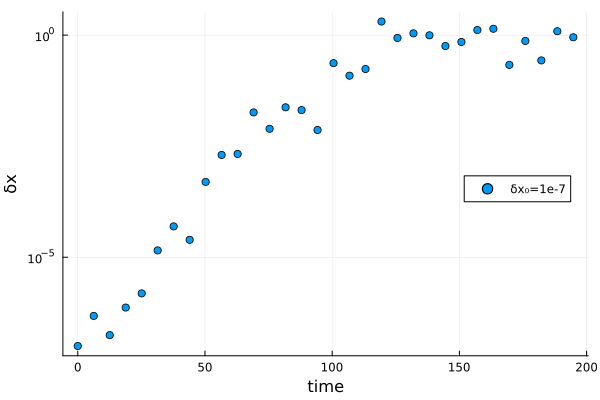

In [5]:
times=collect(0.:2*pi:200)
x1=[traj1b(t)[1] for t in times]
x2=[traj2b(t)[1] for t in times]
scatter(times,abs.(x2-x1),yscale=:log10,
    xlabel="time",ylabel="δx",label="δx₀=1e-7",leg=:right)

That looks nicer, and indeed appears to be well approximated by an exponential -- up until the time that it saturates.  The saturation is simple to understand:  The position is bounded, so the difference in positions can only get so big.

We could fit the $\log(\delta x)$ vs $t$ graph to a straight line, and extract an exponent, which would be $\lambda$:
\begin{equation}
\delta x \sim e^{\lambda t}
\end{equation}

One slightly more sophisticated thing we can do is take the limit where the difference between the starting positions of the two trajectories goes to zero.  That is we look at

\begin{align}
\frac{\partial x(t)}{\partial x_0} = \lim_{\delta x_0\to 0} \frac{\delta x(t)}{\delta x_0}
\end{align}

In fact, what we have now is a *finite differences* approximation to that derivative

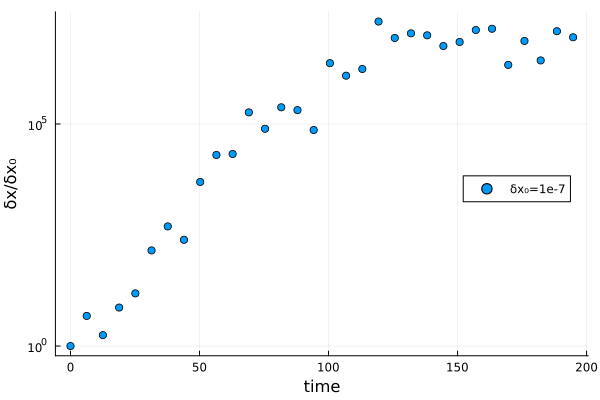

In [6]:
scatter(times,abs.(x2-x1)./(x2[1]-x1[1]),yscale=:log10,
    xlabel="time",ylabel="δx/δx₀",label="δx₀=1e-7",leg=:right)

Rather than this finite difference approach to calculate $\partial x/\partial x_0$ we could use our automatic differentiation code.  In fact the routines in `DifferentialEquations.jl` are compatible with the automatic differentiation packages.  Or we could write our own integrator, which is compatible with our implementation of automatic differentiation.

A somewhat simpler, but equivalent approach involves taking the derivative of our differential equations:

\begin{align}
\partial_t x&= v\\
\partial_t v&=-2\gamma v-\alpha x-\beta x^3 +F \cos(\omega t)
\end{align}

to get

\begin{align}
\partial_t\frac{\partial x}{\partial x_0}&= \frac{\partial v}{\partial x_0}\\
\partial_t \frac{\partial v}{\partial x_0}&=-2\gamma \frac{\partial v}{\partial x_0}-(\alpha +3\beta x^2)\frac{\partial x}{\partial x_0}
\end{align}


Thus we can calculate $\partial x/\partial x_0$ we make a length $4$ vector $\vec{r}=(x,v,dx/dx_0,dv/dx_0)$.  That length 4 vector obeys a known diffential equation.  We can integrate it by using our Differential equations solver:


In [7]:
function duffingJx(initialxv,T,α,β,γ,F,ω)
    function dxvdt(vars,p,t)
        x,v,dxdx0,dvdx0 = vars
        return[v,
            -2*γ*v-α*x-β*x^3+F*cos(ω*t),
            dvdx0,
            -2*γ*dvdx0-(α+3*β*x^2)*dxdx0
        ]
    end
    tspan=[0., T]
    initial=[initialxv...,1,0]
    prob=ODEProblem(dxvdt,initial,tspan)
    solve(prob)
end
duffingJx(initialxv,T;α,β,γ,F,ω)=duffingJx(initialxv,T,α,β,γ,F,ω)
duffingJx(;initialxv,T,α,β,γ,F,ω)=duffingJx(initialxv,T,α,β,γ,F,ω)

duffingJx (generic function with 3 methods)

One advantage of this differential approach is that we no longer see the satturation that we found in our finite differences approach.  This means we can go to longer times, and extract a better exponential

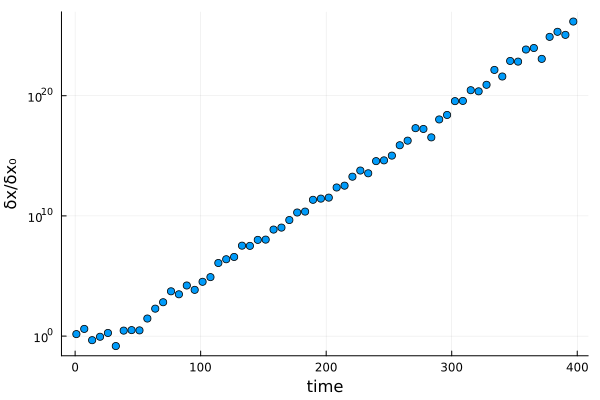

In [8]:
dparamsb=(α=-1,β=1,γ=0.1,F=0.35,ω=1)
dtraj1b=duffingJx([0.1,0],400;dparamsb...);
plot_xt(dtraj1b,0,400,0.1;xlabel="t",ylabel="x",label="x0=0.1")
times1=collect(1:2*pi:400)
dx0dt1b=[dtraj1b(t)[3] for t in times1]
scatter(times1,abs.(dx0dt1b),yscale=:log10,
    xlabel="time",ylabel="δx/δx₀",label="")

Now we just need to find the best fit line.  Lets make a simple object which finds the coefficients of the best fit.  For ease of use, lets make it a function-like object, which can be evaluated at times to act as the fit function.

In [10]:
"""
    expfit(times,values)

finds the coefficients of the best-fit function \$f(t)=A \\exp(b t)\$.  
It returns a function-like object, which can be evaluated at time \$t\$. The coefficients
\$A\$ and \$b\$ can be retrieved as `f.A` or `f.b`
"""
struct expfit
    A
    b
    # constructor
    function expfit(times,values)
        logvals=@. log(abs(values))
        a,b = linearfit(times,logvals,[x->1.,x->x])     
        return new(exp(a),b)
    end
end

(f::expfit)(t)=f.A*exp(f.b*t)

exponent(f::expfit)=f.b

# Our old linear fit function from earlier in the class

"""
    linearfit(X,Y,functions)

takes a set of `X=(x1,x2,...xn)`, `Y=(y1,y1,...yn)` and a set of `functions=(f1, f2,...fm)` 
and returns the set of coefficients `C=(c1,c2,..cm)` which minimize 


         n       m
    χ²=  ∑  (yi- ∑  cj fj(xi))^2
        i=1     j=1

It is implemented by constructing the `n×m` matrix `A` with matrix elements

    Aᵢⱼ= fj(xi)

then `(AᵗA)C=AᵗY`, where `Y=(y1,y2,...yn)`.  Thus the optimal coefficients are 
`(AᵗA)⁻¹(AᵗY)`, which can be implemented with `(AᵗA)\\(AᵗY)`.
"""
function linearfit(X,Y,functions)
    A=[f(x) for x in X, f in functions ]
    return transpose(A)*A\(transpose(A)*Y) # This is equivalent to (AᵗA)⁻¹(AᵗY)
end     

linearfit

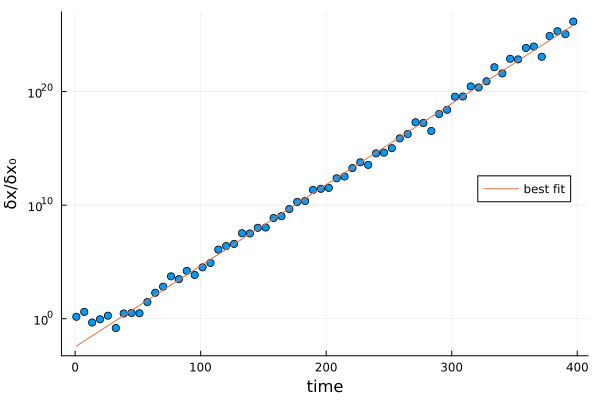

In [15]:
fitfun1b=expfit(times1[10:end],dx0dt1b[10:end])
scatter(times1,abs.(dx0dt1b),yscale=:log10,
    xlabel="time",ylabel="δx/δx₀",label="")
fitvals=[fitfun1b(t) for t in times1]
plot!(times1,fitvals,label="best fit",leg=:right)

In [13]:
(fitfun1b.A,fitfun1b.b)

(0.0032931107196327906, 0.1644267000881052)

Here is a more pedestrian version of this same procedure

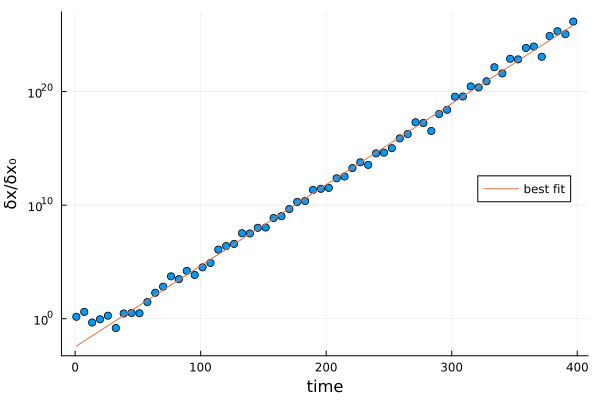

In [16]:
fitvalues=linearfit(times1[10:end],log.(abs.(dx0dt1b[10:end])),[x->1.,x->x])
bestfit(t)=exp(fitvalues[1]+fitvalues[2]*t)
scatter(times1,abs.(dx0dt1b),yscale=:log10,
    xlabel="time",ylabel="δx/δx₀",label="")
fitvals2=[bestfit(t) for t in times1]
plot!(times1,fitvals2,label="best fit",leg=:right)

In [17]:
fitfun1b.b  # the Lyapunov exponent

0.1644267000881052

## Generic Deviations

For our initial conditions we need to specify both $x_0$ and $v_0$.  Therefore the sensitivity to initial conditions is actually encoded in a tensor,
\begin{equation}
J=\left(
\begin{array}{cc}
\frac{\partial x}{\partial x_0}&\frac{\partial x}{\partial v_0}\\
\frac{\partial v}{\partial x_0}&\frac{\partial v}{\partial v_0}
\end{array}
\right)
\end{equation}
This matrix encodes how much the phase space location $(x,v)$ at time $t$ changes when we change initial conditions $(x_0,v_0)$.

The determinant of $J$ tells you how much the volume of phase space has changed from time $t=0$ to time $t$.  IE.  the triangle of phase space bounded by $(x_0,v_0),(x_0+\delta x_0,v_0),(x_0,v_0+\delta v_0)$ maps onto the triangle $(x,v),(x+\delta x_1,v+\delta v_1),(x+\delta x_2,v+\delta v_2)$ where
\begin{align}
\left(\begin{array}{c}
\delta x_1\\\delta v_1
\end{array}
\right)&=
J \left(\begin{array}{c}
\delta x_0\\0
\end{array}
\right)\\
\left(\begin{array}{c}
\delta x_2\\\delta v_2
\end{array}
\right)&=
J \left(\begin{array}{c}
0\\\delta v_0
\end{array}
\right)
\end{align}
The ratio of the areas of those two triangles is $\det J$

For a Hamiltonian (non-disipative system), this determinant will be $1$. When $\gamma\neq 0$ our model is not Hamiltonian, and the phase space volume will not be conserved.  Nonetheless, one can write
\begin{align}
\det J &= \frac{\partial x}{\partial x_0}\frac{\partial v}{\partial v_0}-\frac{\partial x}{\partial v_0}\frac{\partial v}{\partial x_0}\\
&= \{x,v\}
\end{align}
which is referred to as the *Canonical Poisson bracket*.

The Jacobian $J$ describes the stretch and twist of a small patch of phase space.  It is useful to find its eigenvalues and eigenvectors.  The eigenvalues $j_1,j_2$ tell you how much phase space is squeezed or stretched along the principle axes.  For a Hamiltonian system $j_1\times j_2=1$, meaning that you stretch along one direction, and shrink along the other.  

We define the (local) Lyapanov exponent from the time dependence of  eigenvalue of $J$ with the largest magnitude.

In [18]:
using LinearAlgebra
eigvals([1. 1.; 1. 1.])

2-element Vector{Float64}:
 0.0
 2.0

In [19]:
function duffingJ(initialxv,T,α,β,γ,F,ω)
    function dxvdt(vars,p,t)
        x,v,dxdx0,dvdx0,dxdv0,dvdv0 = vars
        return[
            #= change in x=# v,
            #= change in x=# -2*γ*v-α*x-β*x^3+F*cos(ω*t),
            #= change in dx/dx0=# dvdx0,
            #= change in dv/dx0=#-2*γ*dvdx0-(α+3*β*x^2)*dxdx0,
            #= change in dx/dv0=# dvdv0,
            #= change in dv/dx0=#-2*γ*dvdv0-(α+3*β*x^2)*dxdv0
        ]
    end
    tspan=[0., T]
    initial=[initialxv...,1,0,0,1]
    prob=ODEProblem(dxvdt,initial,tspan)
    solve(prob)
end
duffingJ(initialxv,T;α,β,γ,F,ω)=duffingJ(initialxv,T,α,β,γ,F,ω)
duffingJ(;initialxv,T,α,β,γ,F,ω)=duffingJ(initialxv,T,α,β,γ,F,ω)

duffingJ (generic function with 3 methods)

In [20]:
function jacobian(vars)
    return [vars[3] vars[4]; vars[5] vars[6]]
end

largestev(mat)=max(abs.(eigvals(mat))...)

largestev (generic function with 1 method)

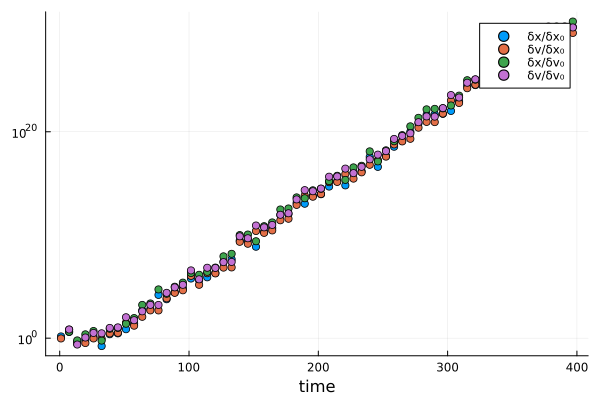

In [21]:
dparamsb=(α=-1,β=1,γ=0.1,F=0.35,ω=1)
Jtraj1b=duffingJ([0.1,0],400;dparamsb...);
times1=collect(1:2*pi:400)
Jdxdx0=[Jtraj1b(t)[3] for t in times1]
Jdv0x0=[Jtraj1b(t)[4] for t in times1]
Jdxdv0=[Jtraj1b(t)[5] for t in times1]
Jdvdv0=[Jtraj1b(t)[6] for t in times1]
scatter(times1,abs.(Jdxdx0),yscale=:log10,   
    xlabel="time",label="δx/δx₀")
scatter!(times1,abs.(Jdv0x0),yscale=:log10,   
    xlabel="time",label="δv/δx₀")
scatter!(times1[2:end],abs.(Jdxdv0)[2:end],yscale=:log10,   
    xlabel="time",label="δx/δv₀")
scatter!(times1[2:end],abs.(Jdvdv0)[2:end],yscale=:log10,   
    xlabel="time",label="δv/δv₀")

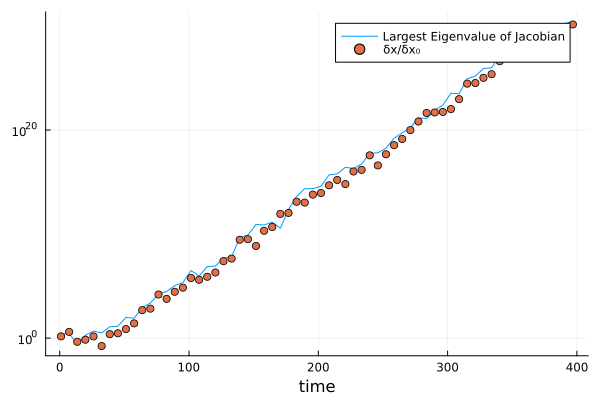

In [22]:
plot(times1,[largestev(jacobian(Jtraj1b(t))) for t in times1],
    yscale=:log10,label="Largest Eigenvalue of Jacobian")
scatter!(times1,abs.(Jdxdx0),yscale=:log10,   
    xlabel="time",label="δx/δx₀")

Clearly finding the Jacobian was not so important:  we will essentially get the same result as when we just used dx/dx0.  Nonetheless, we now have access to what is happening to the phase space volume

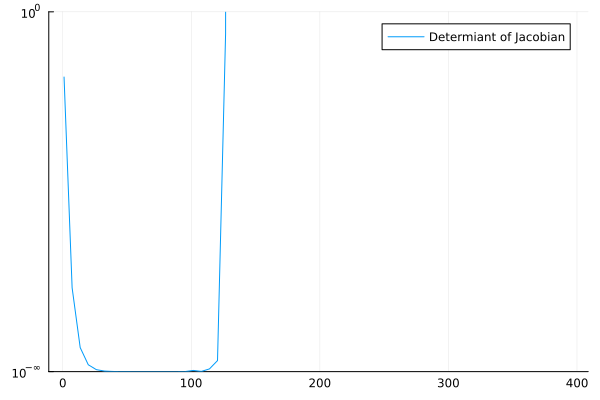

┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194


In [23]:
plot(times1,[abs(det(jacobian(Jtraj1b(t)))) for t in times1],
    label="Determiant of Jacobian",ylim=(0,1),yscale=:log10)

At short time the phase space volume exponentially falls, but after about time 100, it starts oscillating wildly.  Those oscillations are unphysical, and are a sign of some sort of numerical error.  The problem is that the Jacobian has one very large eigenvalue, and one very large eigenvalue.  These are on such different scales that we can't get them both right using machine precision.  The determinant, which is the product of the eigenvalues, gets messed up when we are no longer able to sensibly extract the smaller eigenvalue.

We say that the Jacobian at long times is ill-conditioned.  Nonetheless, the largest eigenvalue is still reliable.  There are tricks to fixing this, based on either QR decomposition or repeated Gram-Schmidt orthogonalization.  We will discuss both QR decomposition and the Gram-Schmidt algorithm later in the course (but will probably not have a chance to explain how to apply it here).  [Here is a pretty readible paper on the Gram-Schmidt approach.](https://venturi.soe.ucsc.edu/sites/default/files/Numerical_Calculation_of_Lyapunov_Exponents.pdf)

The fact that one of the eigenvalues becomes very small means that all of phase space is collapsing onto a line.  This line is twisted around in space:

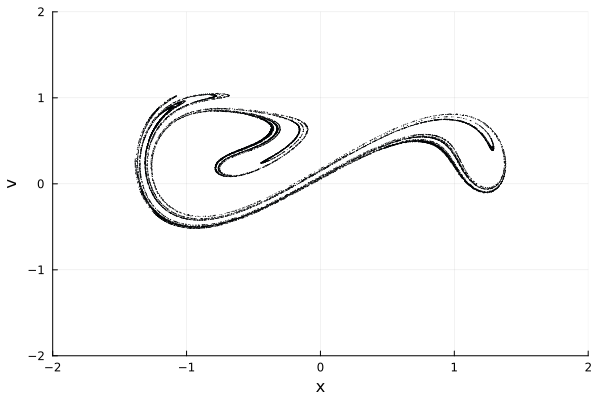

In [24]:
longtraj1b=duffing([0.1,0],100000;dparamsb...);
scatter_xv(longtraj1b,2*pi*500,100000,2*pi;xlabel="x",ylabel="v",label="",
    xrange=[-2,2],yrange=[-2,2],markersize=0.1)

Now we can make a function which calculates the (local) Lyapunov exponent

In [25]:
function Lyupanov(initialxv,T,α,β,γ,F,ω)
    trajectory=duffingJ(initialxv,T,α,β,γ,F,ω);
    times=collect(1:2*pi/ω:T)
    Jevs=[largestev(jacobian(trajectory(t))) for t in times]
    return exponent(expfit(times,Jevs))
end
Lyupanov(initialxv,T;α,β,γ,F,ω)=Lyupanov(initialxv,T,α,β,γ,F,ω)
Lyupanov(;initialxv,T,α,β,γ,F,ω)=Lyupanov(initialxv,T,α,β,γ,F,ω)

Lyupanov (generic function with 3 methods)

In [26]:
Lyupanov([0.1,0],400;dparamsb...)

0.1933920328078582

In [27]:
Lyupanov(;initialxv=[0.1,0],T=400,α = -1, β = 1, γ = 0.1, F = 0.35, ω = 1.)

0.1933920328078582

In [29]:
@time sweep1=[(F,Lyupanov(;initialxv=[0.1,0],T=400,α=-1,β=1,γ=0.1,F=F,ω=1.))
    for F in 0.:.0025:0.6];

  1.068108 seconds (20.54 M allocations: 2.065 GiB, 12.51% gc time, 2.57% compilation time)


In [30]:
@time sweep2=[(F,Lyupanov(;initialxv=[1.1,0],T=400,α=-1,β=1,γ=0.1,F=F,ω=1.)) 
    for F in 0.:.0025:0.6];

  0.971183 seconds (19.09 M allocations: 1.963 GiB, 13.87% gc time, 2.24% compilation time)


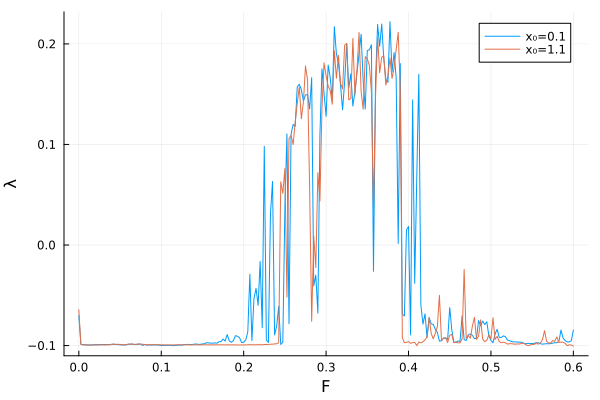

In [31]:
plot(sweep1,xlabel="F",ylabel="λ",label="x₀=0.1")
plot!(sweep2,label="x₀=1.1")

The regions of positive Lyupanov Exponent form a fractal in parameter space

In [32]:
ωvals=0.5:0.005:1.5
Fvals=0.2:0.005:0.6
@time lyupgrid=[Lyupanov(;initialxv=[1.1,0],T=50,α=-1,β=1,γ=0.1,F=F,ω=ω) for F in Fvals, 
        ω in ωvals];

  8.358028 seconds (169.55 M allocations: 17.882 GiB, 14.22% gc time, 0.40% compilation time)


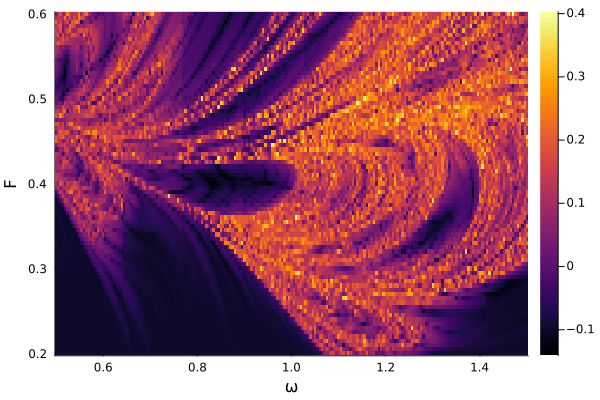

In [33]:
heatmap(ωvals,Fvals,lyupgrid,xlabel="ω",ylabel="F")